### V gene limited 

In [1]:
def extract_gene_symbol(description):
    parts = description.split(' ')
    for part in parts:
        if part.startswith('gene_symbol:'):
            return part.split(':')[1]
    return None


    
def get_common_gene():
    # cds_gene_set
    cds_dic = {}
    fasta_file = "Homocdsall.fasta"  
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_symbol = extract_gene_symbol(record.description)
        if gene_symbol != None:
            cds_dic[gene_symbol] = str(record.seq)
    print("cds_dic:", len(cds_dic))
    cds_gene_set = set(cds_dic.keys())
    
    # cds_pro_set
    pep_dic = {}
    fasta_file = "Homopepall.fasta"  
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_symbol = extract_gene_symbol(record.description)
        if gene_symbol != None:
            pep_dic[gene_symbol] = str(record.seq)
    print("pep_dic:", len(pep_dic))
    cds_pro_set = set(pep_dic.keys())
    
    
    # common_gene_list
    common_gene_list = list(cds_gene_set & cds_pro_set)
    print("common_gene_list", len(common_gene_list))
    return common_gene_list

In [6]:
import pickle
with open('cds_DNA_features_dic.pkl', 'rb') as f:    
    cds_features_dic = pickle.load(f)

/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
with open('cds_pro_features_dic.pkl', 'rb') as f:    
    cds_pro_features_dic = pickle.load(f)

In [2]:
def V_split(common_gene_list, train_ratio, neg_ratio):
    random.seed(42)
    
    # 按照8:2比例随机划分V基因
    random.shuffle(common_gene_list)
    split_index = int(train_ratio * len(common_gene_list))

    train_gene_set = common_gene_list[:split_index]
    test_gene_set = common_gene_list[split_index:]
    
    ## 划分正样本集合
    DD_DU_train = {}
    # Load spreadsheet
    xl = pd.ExcelFile('all_cancer_pair.xlsx')

    df = xl.parse(xl.sheet_names[0], skiprows=3)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[1] in train_gene_set:
            DD_DU_train[row[0], row[1]] = 1

    df = xl.parse(xl.sheet_names[2], skiprows=2)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[1] in train_gene_set:
            DD_DU_train[row[0], row[1]] = 1

    DD_DU_test = {}
    # Load spreadsheet
    xl = pd.ExcelFile('all_cancer_pair.xlsx')

    df = xl.parse(xl.sheet_names[0], skiprows=3)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[1] in test_gene_set:
            DD_DU_test[row[0], row[1]] = 1
        # DD_DU_train[row[0], row[1]] = 1

    df = xl.parse(xl.sheet_names[2], skiprows=2)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[1] in test_gene_set:
            DD_DU_test[row[0], row[1]] = 1

    #print(len(DD_DU_test), len(DD_DU_train))
    DD_DU_all = set(DD_DU_train.keys()) | set(DD_DU_test.keys())
    
    
    ## 划分负样本集合
    # random.seed(127)
    DU_DD_ra_train = {}
    for i in range(neg_ratio * len(DD_DU_train)):
        a = train_gene_set[ random.randint(0, len(train_gene_set)-1) ]
        b = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]

        while a == b or (b, a) in DD_DU_all or (b, a) in DU_DD_ra_train:
            b = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]
        DU_DD_ra_train[b,a] = 0

    DU_DD_ra_test = {}
    for i in range(neg_ratio * len(DD_DU_test)):
        a = test_gene_set[ random.randint(0, len(test_gene_set)-1) ]
        b = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]

        while a == b or (b, a) in DD_DU_all or (b, a) in DU_DD_ra_test:
            b = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]
        DU_DD_ra_test[b,a] = 0

    return DD_DU_train, DD_DU_test, DU_DD_ra_train, DU_DD_ra_test


In [3]:
def combine_X(gene_pair, cds_features_dic, cds_pro_features_dic):
    geneA1_features = cds_features_dic[gene_pair[0]]
    geneB1_features = cds_features_dic[gene_pair[1]]
    geneA2_features = cds_pro_features_dic[gene_pair[0]]
    geneB2_features = cds_pro_features_dic[gene_pair[1]]       
    return np.concatenate([geneA1_features, geneB1_features, 
                    geneA2_features, geneB2_features])


def build_train_test(DD_DU_train, DD_DU_test, DU_DD_ra_train, DU_DD_ra_test):
    with open('cds_DNA_features_dic.pkl', 'rb') as f:    
        cds_features_dic = pickle.load(f)
    with open('cds_pro_features_dic.pkl', 'rb') as f:   
        cds_pro_features_dic = pickle.load(f)
    
    # Prepare the train dataset
    X_train = []
    y_train = []

    # positive sample processing
    for gene_pair, label in DD_DU_train.items():
        try:
            X_train.append(combine_X(gene_pair, cds_features_dic, cds_pro_features_dic))
            y_train.append(label)
        except:
            #print(gene_pair)
            pass

    # negative sample processing
    for gene_pair, label in DU_DD_ra_train.items():
        try:
            X_train.append(combine_X(gene_pair, cds_features_dic, cds_pro_features_dic))
            y_train.append(label)
        except:
            #print(gene_pair)
            pass

    # Prepare the test dataset
    X_test = []
    y_test = []

    # positive sample processing
    for gene_pair, label in DD_DU_test.items():
        try:
            X_test.append(combine_X(gene_pair, cds_features_dic, cds_pro_features_dic))
            y_test.append(label)
        except:
            #print(gene_pair)
            pass

    # negative sample processing
    for gene_pair, label in DU_DD_ra_test.items():
        try:
            X_test.append(combine_X(gene_pair, cds_features_dic, cds_pro_features_dic))
            y_test.append(label)
        except:
            #print(gene_pair)
            pass
        
    return X_train, y_train, X_test, y_test

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize
from itertools import cycle
from Bio import SeqIO
import pandas as pd
import random


common_gene_list = get_common_gene()
DD_DU_train, DD_DU_test, DU_DD_ra_train, DU_DD_ra_test = V_split(common_gene_list, train_ratio=0.8, neg_ratio=10)
X_train, y_train, X_test, y_test = build_train_test(DD_DU_train, DD_DU_test, DU_DD_ra_train, DU_DD_ra_test)


cds_dic: 19852
pep_dic: 19852
common_gene_list 19852


/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
def run_MLP(X_train, X_test, y_train, y_test, 
            batch_size, learning_rate, weight_decay, num_train_epochs):
    # Apply SMOTE to generate synthetic samples
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # create the MLP model
    model = MLPClassifier(hidden_layer_sizes=(256, 32),
                          activation='relu',
                          solver='adam',
                          alpha=weight_decay,
                          batch_size=batch_size,
                          learning_rate='constant',
                          learning_rate_init=learning_rate,
                          power_t=0.5,
                          max_iter=num_train_epochs,  # train for num_train_epochs at a time
                          shuffle=True,
                          random_state=42,
                          tol=1e-7,  # disable early stopping
                          verbose=False, # not print progress messages
                          validation_fraction=0.1,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=1e-8,
                          n_iter_no_change=10,
                          max_fun=15000)

    train_losses = []
    validation_losses = []
    for _ in range(num_train_epochs):
        # Fit the model for one epoch
        model.partial_fit(X_train, y_train, classes=np.unique(y_train))

        # Get the training loss
        train_loss = model.loss_
        train_losses.append(train_loss)

        # Calculate the validation loss
        validation_proba = model.predict_proba(X_test)
        validation_loss = log_loss(y_test, validation_proba)
        validation_losses.append(validation_loss)
        
        print('train_loss', round(train_loss,3), 'validation_loss', round(validation_loss,3))

    return model, train_losses, validation_losses

train_loss 0.572 validation_loss 0.508
train_loss 0.423 validation_loss 0.337
train_loss 0.336 validation_loss 0.298
train_loss 0.278 validation_loss 0.279
train_loss 0.234 validation_loss 0.269
train_loss 0.199 validation_loss 0.264
train_loss 0.17 validation_loss 0.261
train_loss 0.145 validation_loss 0.262
train_loss 0.125 validation_loss 0.264
train_loss 0.107 validation_loss 0.267
train_loss 0.091 validation_loss 0.272
train_loss 0.078 validation_loss 0.277
train_loss 0.067 validation_loss 0.283
train_loss 0.057 validation_loss 0.29
train_loss 0.049 validation_loss 0.297


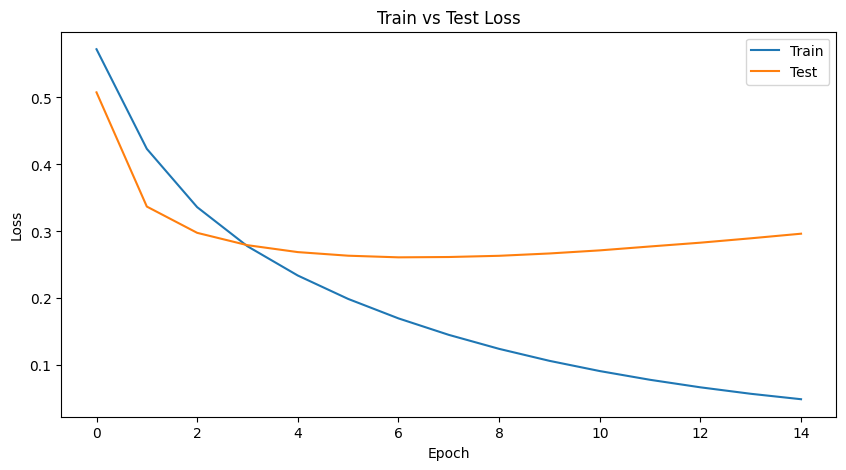

[[4999  221]
 [ 237  271]]
Precision: 0.55
Recall: 0.53
F1 Score: 0.54


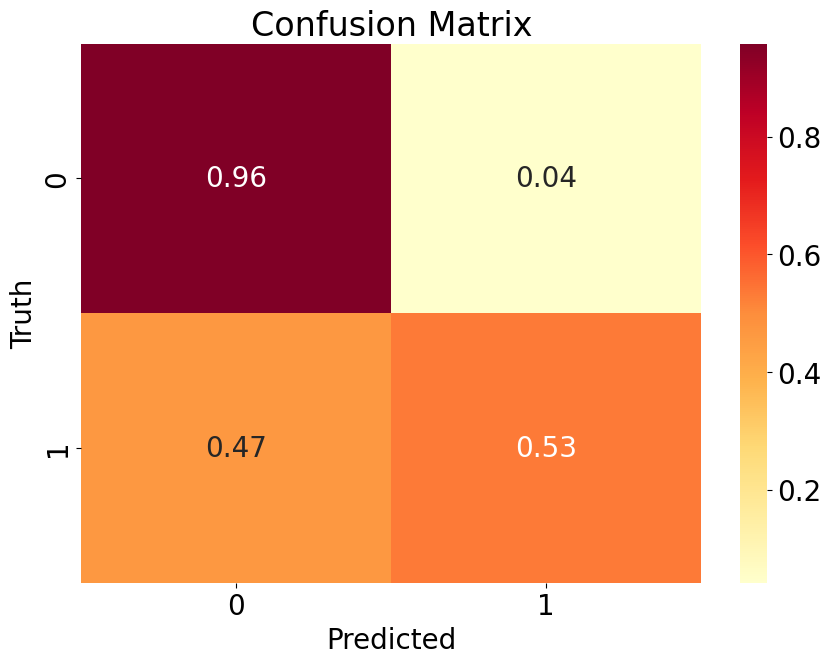

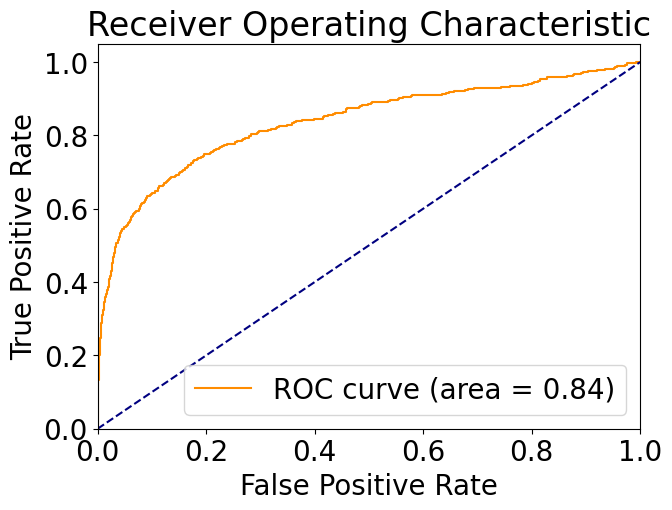

In [11]:
# Run the MLP model
num_train_epochs = 15
model, train_losses, validation_losses = run_MLP(
    X_train, X_test, y_train, y_test, batch_size=100, 
    learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_train_epochs), train_losses, label='Train')
plt.plot(range(num_train_epochs), validation_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Test Loss')
plt.show()

# Predict probabilities for the test data
probs = model.predict_proba(X_test)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Calculate confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(cm)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# one-time AUC and cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

# Set global font size
plt.rcParams.update({'font.size': 20})

# Normalize the confusion matrix
cm_normalized = normalize(cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### R gene limited 

In [12]:
def R_split(common_gene_list, train_ratio, neg_ratio):
    random.seed(42)
    
    # 按照8:2比例随机划分基因
    random.shuffle(common_gene_list)
    split_index = int(train_ratio * len(common_gene_list))

    train_gene_set = common_gene_list[:split_index]
    test_gene_set = common_gene_list[split_index:]
    
    ## 划分正样本集合
    DD_DU_train = {}
    # Load spreadsheet
    xl = pd.ExcelFile('all_cancer_pair.xlsx')

    df = xl.parse(xl.sheet_names[0], skiprows=3)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[0] in train_gene_set:
            DD_DU_train[row[0], row[1]] = 1

    df = xl.parse(xl.sheet_names[2], skiprows=2)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[0] in train_gene_set:
            DD_DU_train[row[0], row[1]] = 1

    DD_DU_test = {}
    # Load spreadsheet
    xl = pd.ExcelFile('all_cancer_pair.xlsx')

    df = xl.parse(xl.sheet_names[0], skiprows=3)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[0] in test_gene_set:
            DD_DU_test[row[0], row[1]] = 1
        # DD_DU_train[row[0], row[1]] = 1

    df = xl.parse(xl.sheet_names[2], skiprows=2)
    for index, row in df.iterrows():
    # Use the first and second column values as a key, and set the value as 1
        if row[0] in test_gene_set:
            DD_DU_test[row[0], row[1]] = 1

    #print(len(DD_DU_test), len(DD_DU_train))
    DD_DU_all = set(DD_DU_train.keys()) | set(DD_DU_test.keys())
    
    
    ## 划分负样本集合
    # random.seed(127)
    DU_DD_ra_train = {}
    for i in range(neg_ratio * len(DD_DU_train)):
        b = train_gene_set[ random.randint(0, len(train_gene_set)-1) ]
        a = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]

        while a == b or (b, a) in DD_DU_all or (b, a) in DU_DD_ra_train:
            b = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]
        DU_DD_ra_train[b,a] = 0

    DU_DD_ra_test = {}
    for i in range(neg_ratio * len(DD_DU_test)):
        b = test_gene_set[ random.randint(0, len(test_gene_set)-1) ]
        a = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]

        while a == b or (b, a) in DD_DU_all or (b, a) in DU_DD_ra_test:
            b = common_gene_list[ random.randint(0, len(common_gene_list)-1) ]
        DU_DD_ra_test[b,a] = 0

    return DD_DU_train, DD_DU_test, DU_DD_ra_train, DU_DD_ra_test

In [13]:
common_gene_list = get_common_gene()
DD_DU_train, DD_DU_test, DU_DD_ra_train, DU_DD_ra_test = R_split(common_gene_list, train_ratio=0.8, neg_ratio=10)
X_train, y_train, X_test, y_test = build_train_test(DD_DU_train, DD_DU_test, DU_DD_ra_train, DU_DD_ra_test)

cds_dic: 19852
pep_dic: 19852
common_gene_list 19852


/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/data1/xpgeng/.conda/envs/pytorch/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


train_loss 0.564 validation_loss 0.5
train_loss 0.418 validation_loss 0.426
train_loss 0.332 validation_loss 0.378
train_loss 0.275 validation_loss 0.353
train_loss 0.232 validation_loss 0.33
train_loss 0.197 validation_loss 0.314
train_loss 0.167 validation_loss 0.298
train_loss 0.143 validation_loss 0.289
train_loss 0.122 validation_loss 0.283
train_loss 0.104 validation_loss 0.281
train_loss 0.089 validation_loss 0.282
train_loss 0.076 validation_loss 0.286
train_loss 0.065 validation_loss 0.292
train_loss 0.056 validation_loss 0.3
train_loss 0.049 validation_loss 0.309


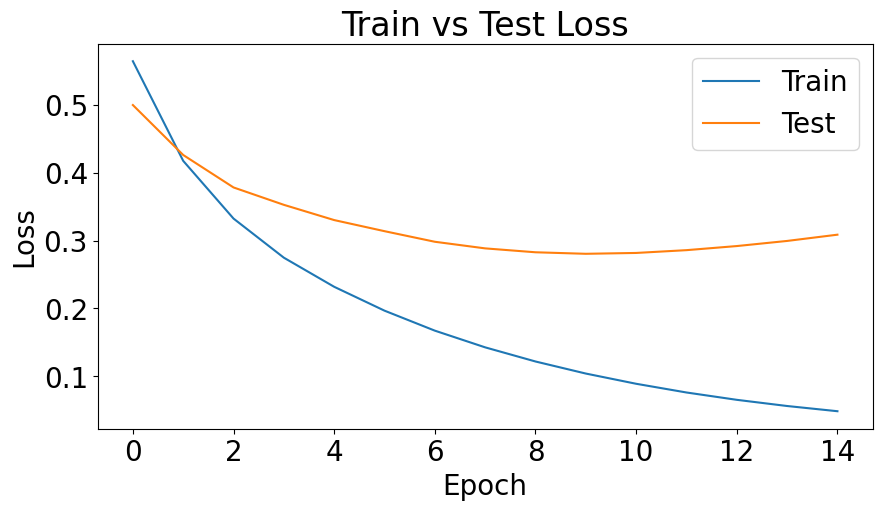

[[4865  185]
 [ 279  207]]
Precision: 0.53
Recall: 0.43
F1 Score: 0.47


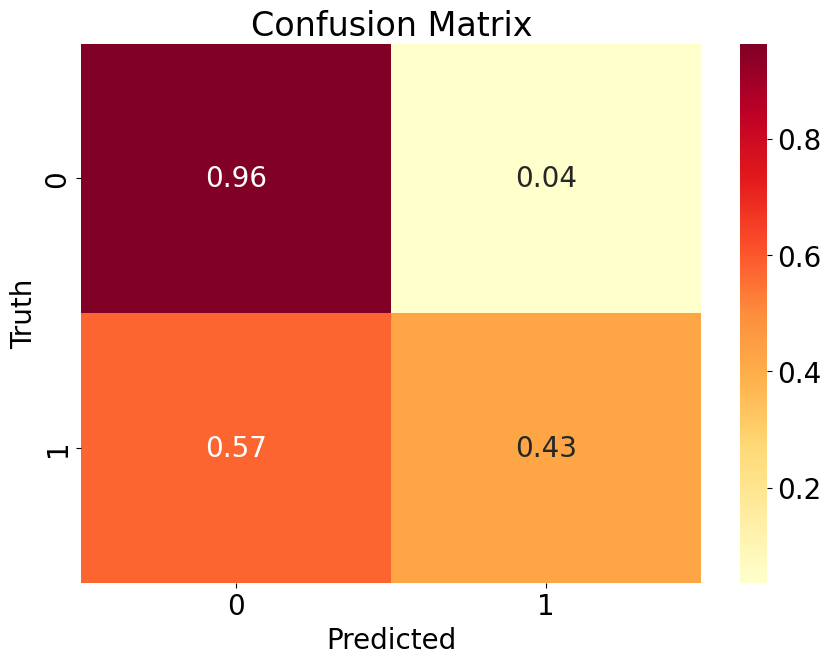

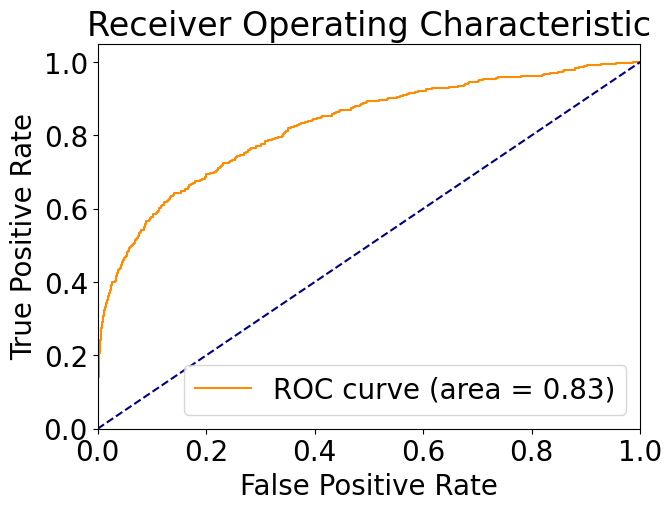

In [14]:
# Run the MLP model
num_train_epochs = 15
model, train_losses, validation_losses = run_MLP(
    X_train, X_test, y_train, y_test, batch_size=100, 
    learning_rate=1e-4, weight_decay=1e-3, num_train_epochs=num_train_epochs)

# Plot train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(num_train_epochs), train_losses, label='Train')
plt.plot(range(num_train_epochs), validation_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Test Loss')
plt.show()

# Predict probabilities for the test data
probs = model.predict_proba(X_test)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Calculate confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(cm)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# one-time AUC and cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

# Set global font size
plt.rcParams.update({'font.size': 20})

# Normalize the confusion matrix
cm_normalized = normalize(cm, axis=1, norm='l1')

# Plot confusion matrix using seaborn with warmer colors
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()